In [19]:
using DifferentialEquations, PyPlot, Distributions, LaTeXStrings, StanSample

┌ Info: Precompiling StanSample [c1514b29-d3a0-5178-b312-660c88baa699]
└ @ Base loading.jl:1273


In [5]:
theta = [0.25, 0.1] # γ, λ
P = 1.0
T = 30.0
dt = 1.0
t = collect(0:dt:T);

In [6]:
dxdt(u,p,t) = p[1]*u - p[2]*u^2
tspan = (0,T)
prob = ODEProblem(dxdt, P, tspan, theta)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 30.0)
u0: 1.0

In [7]:
sol = solve(prob,reltol=1e-6,saveat=1.0);

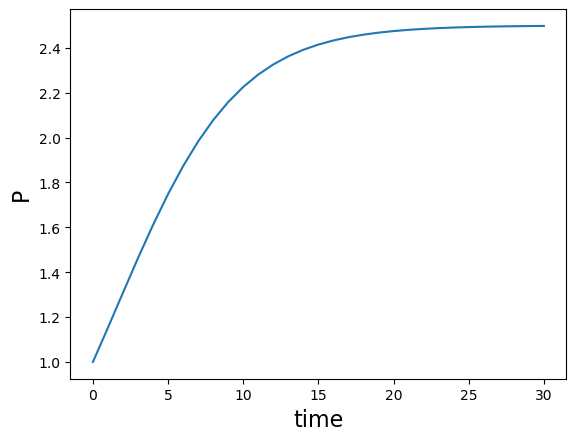

In [11]:
fig, ax = PyPlot.subplots()
ax.plot(sol.u)
ax.set_ylabel("P",fontsize=16)
ax.set_xlabel("time",fontsize=16);

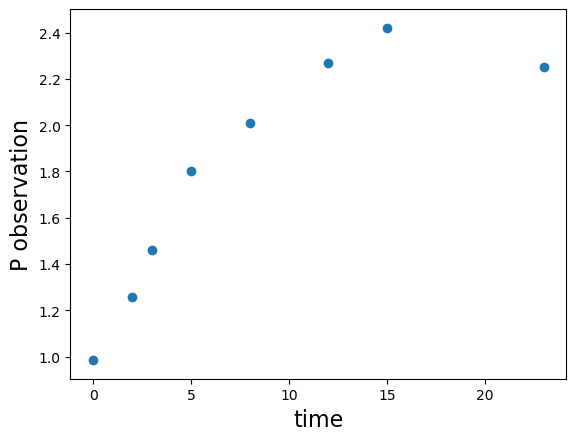

In [49]:
t_obs_ind = [1,3,4,6,9,13,16,24];
obs = sol.u[t_obs_ind] .+ rand(Normal(0,0.1),size(t_obs_ind,1))
t_obs = sol.t[t_obs_ind];
fig, ax = PyPlot.subplots()
ax.scatter(t_obs,obs)
ax.set_ylabel("P observation",fontsize=16)
ax.set_xlabel("time",fontsize=16);

In [18]:
stancode = "functions {
   real[] P_growth(real t,       // time
                   real[] x,      // state
                   real[] theta, // parameters
                   real[] x_r,   // environmental data
                   int[] x_i){
    real gamma  = theta[1];
    real lambda = theta[2];

    real growth = gamma*x[1];
    real loss   = lambda*x[1]*x[1];
    
    return {growth - loss};
  }
}
data {
    int<lower = 0> N;           // num obs
    real t_obs[N];              // obs times
    real<lower = 0> y[N];       // observed variable at measurement times
    real sigma;
}
parameters {
    real<lower=0,upper=1> theta[2];      // parameters
    real<lower=0> x0[1];
}
transformed parameters {
    real x[N,1] = integrate_ode_rk45(P_growth, x0, -1, t_obs, theta,
                                      rep_array(0.0, 0), rep_array(0, 0),
                                      1e-6, 1e-5, 1e3);
}
model {
    //theta[1] ~ normal(0.1, 2);
    //theta[2] ~ normal(0.1, 2);
    x0       ~ normal(1.0, 10);
    y[1:N]   ~ normal(x[1:N,1], sigma); // obs
}";

In [20]:
pgrowthdata = Dict("N" => size(t_obs,1), "t_obs" => t_obs, "y" => obs, "sigma" => 0.1);

In [21]:
sm = SampleModel("PgrowthModel", stancode)


/Users/zhenwu/Zhen_WU/Stan_julia/Pgrowth/tmp/PgrowthModel.stan updated.


In [22]:
(sample_file, log_file) = stan_sample(sm, data=pgrowthdata, n_chains = 4);

In [23]:
chns = read_samples(sm)

Object of type Chains, with data of type 1000×18×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = accept_stat__, divergent__, energy__, lp__, n_leapfrog__, stepsize__, treedepth__
parameters        = theta.1, theta.2, x0.1, x.1.1, x.2.1, x.3.1, x.4.1, x.5.1, x.6.1, x.7.1, x.8.1

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean     │ std       │ naive_se    │ mcse        │
│     │ Symbol     │ Float64  │ Float64   │ Float64     │ Float64     │
├─────┼────────────┼──────────┼───────────┼─────────────┼─────────────┤
│ 1   │ theta.1    │ 0.281678 │ 0.0435772 │ 0.000689016 │ 0.00155096  │
│ 2   │ theta.2    │ 0.110241 │ 0.0193633 │ 0.000306161 │ 0.000676124 │
│ 3   │ x0.1       │ 0.802426 │ 0.0912497 │ 0.00144279  │ 0.0033306   │
│ 4   │ x.1.1      │ 0.963248 │ 0.0794767 │ 0.00125664  │ 0.00283218  │
│ 5   │ x.2.1      │ 1.31523  │ 0.

In [24]:
ESS = ess(chns)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ theta.1    │ 729.87  │ 1.00333  │
│ 2   │ theta.2    │ 729.964 │ 1.00292  │
│ 3   │ x0.1       │ 788.039 │ 1.00234  │
│ 4   │ x.1.1      │ 844.283 │ 1.0021   │
│ 5   │ x.2.1      │ 1660.09 │ 1.0015   │
│ 6   │ x.3.1      │ 2667.49 │ 1.00196  │
│ 7   │ x.4.1      │ 1338.07 │ 1.00346  │
│ 8   │ x.5.1      │ 1113.45 │ 1.00354  │
│ 9   │ x.6.1      │ 3142.7  │ 1.00095  │
│ 10  │ x.7.1      │ 3111.12 │ 0.999852 │
│ 11  │ x.8.1      │ 1368.03 │ 1.00035  │

In [25]:
rawdata = DataFrame(chns, showall=true, sorted=true, append_chains=true);

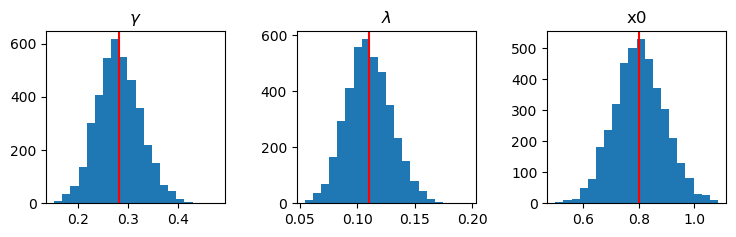

In [27]:
cnames=[L"\gamma",L"\lambda","x0"]
fig, axs = PyPlot.subplots(1, 3, figsize = (8,2))
for i in 1:3
    axs[i].hist(rawdata[:,i],bins=20)
    axs[i].axvline(chns.info[1].x[2][1][i,2],color="r")
    axs[i].set_title(cnames[i], ha="center", fontsize=12, color = "k");
end

fig.subplots_adjust(bottom=0.1, top=0.96, left=0.1, right=0.95,
                    wspace=0.4, hspace=0.1)

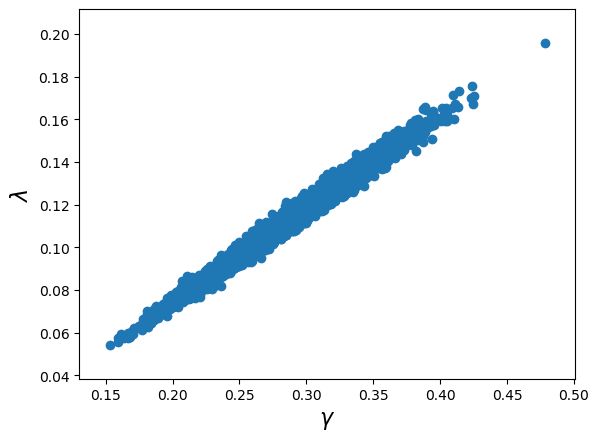

In [32]:
fig, ax = PyPlot.subplots()
ax.scatter(rawdata[:,1],rawdata[:,2],marker = "o")
ax.set_ylabel(L"\lambda",fontsize=16)
ax.set_xlabel(L"\gamma",fontsize=16);

### Periodic P Growth

In [35]:
theta_sin = [0.25, 0.1]
P0 = 2.5
T_sin = 365*4
dt_sin = 1.0
t_sin = collect(0:dt_sin:T_sin);

In [39]:
dxdt_sin(u,p,t) = p[1]*(1+sin(2*π/365*t))*u - p[2]*u^2
tspan_sin = (0.0,T_sin)
prob_sin = ODEProblem(dxdt_sin, P0, tspan_sin, theta_sin)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1460.0)
u0: 2.5

In [40]:
sol_sin= solve(prob_sin,reltol=1e-6,saveat=1.0);

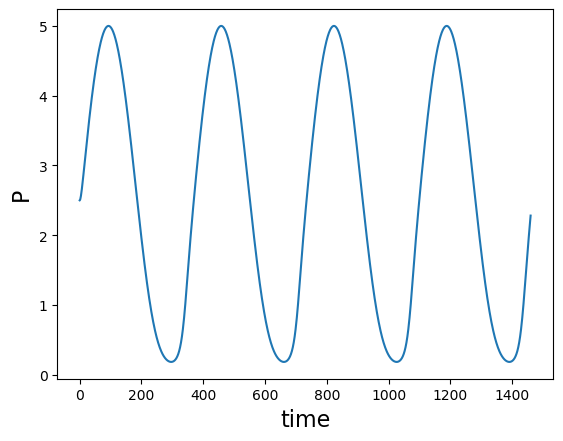

In [41]:
fig, ax = PyPlot.subplots()
ax.plot(sol_sin.u)
ax.set_ylabel("P",fontsize=16)
ax.set_xlabel("time",fontsize=16);

In [73]:
t_obs_ind_sin = sample(1:size(t_sin,1),50,replace=false);
t_obs_ind_sin = sort(t_obs_ind_sin);
t_obs_sin = t_sin[t_obs_ind_sin]
obs_sin = sol_sin.u[t_obs_ind_sin].+ rand(Normal(0,0.1),size(t_obs_ind_sin,1));

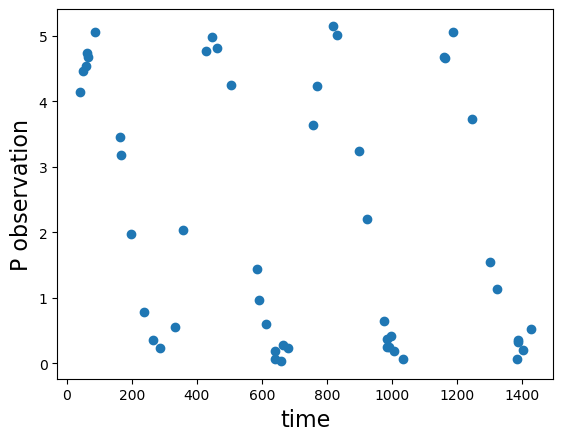

In [74]:
fig, ax = PyPlot.subplots()
ax.scatter(t_obs_sin,obs_sin)
ax.set_ylabel("P observation",fontsize=16)
ax.set_xlabel("time",fontsize=16);

In [75]:
stancode_sin = "functions {
   real[] P_growth(real t,       // time
                   real[] x,      // state
                   real[] theta, // parameters
                   real[] x_r,   // environmental data
                   int[] x_i){
    real gamma  = theta[1];
    real lambda = theta[2];
    //real a      = theta[3];

    real growth = gamma*x[1] + gamma*sin(2*pi()*(1.0/365.0)*t)*x[1];
    real loss   = lambda*x[1]*x[1];
    
    return {growth - loss};
  }
}
data {
    int<lower = 0> N;           // num obs
    real<lower = 0> t_obs[N];              // obs times
    real<lower = 0> y[N];       // observed variable at measurement times
    //real<lower = 0> sigma;
}
parameters {
    real<lower=0> theta[2];      // parameters
    real<lower=0> x0[1];
    real<lower=1E-15> sigma;
}
transformed parameters {
    real<lower=0> x[N,1] = integrate_ode_rk45(P_growth, x0, 1, t_obs, theta,
                                      rep_array(0.0, 0), rep_array(0, 0),
                                      1e-6, 1e-6, 1e5);
}
model {
    theta[1] ~ normal(0.1, 1);
    theta[2] ~ normal(0.1, 1);
    //theta[3] ~ normal(0.01,1);
    x0       ~ normal(1.0, 10);
    y[1:N]   ~ normal(x[1:N,1], sigma); // obs
}";

In [84]:
pgrowthdata_sin = Dict("N" => size(t_obs_sin,1), "t_obs" => t_obs_sin, "y" => obs_sin);

In [85]:
sm_sin = SampleModel("PgrowthModel_sin", stancode_sin)

In [86]:
(sample_file, log_file) = stan_sample(sm_sin, data=pgrowthdata_sin, n_chains = 4);

In [87]:
chns_sin = read_samples(sm_sin)

Object of type Chains, with data of type 1000×61×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = accept_stat__, divergent__, energy__, lp__, n_leapfrog__, stepsize__, treedepth__
parameters        = sigma, theta.1, theta.2, x0.1, x.1.1, x.2.1, x.3.1, x.4.1, x.5.1, x.6.1, x.7.1, x.8.1, x.9.1, x.10.1, x.11.1, x.12.1, x.13.1, x.14.1, x.15.1, x.16.1, x.17.1, x.18.1, x.19.1, x.20.1, x.21.1, x.22.1, x.23.1, x.24.1, x.25.1, x.26.1, x.27.1, x.28.1, x.29.1, x.30.1, x.31.1, x.32.1, x.33.1, x.34.1, x.35.1, x.36.1, x.37.1, x.38.1, x.39.1, x.40.1, x.41.1, x.42.1, x.43.1, x.44.1, x.45.1, x.46.1, x.47.1, x.48.1, x.49.1, x.50.1

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean     │ std        │ naive_se    │ mcse        │
│     │ Symbol     │ Float64  │ Float64    │ Float64     │ Float64     │
├─────┼────────────┼──────────┼────────────┼──────

In [88]:
ESS = ess(chns_sin)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ sigma      │ 1606.34 │ 1.00232  │
│ 2   │ theta.1    │ 1376.25 │ 1.00158  │
│ 3   │ theta.2    │ 1376.14 │ 1.00166  │
│ 4   │ x0.1       │ 2122.6  │ 1.00085  │
│ 5   │ x.1.1      │ 3158.75 │ 0.999295 │
│ 6   │ x.2.1      │ 3396.83 │ 0.999332 │
│ 7   │ x.3.1      │ 3510.51 │ 0.99937  │
│ 8   │ x.4.1      │ 3542.11 │ 0.999386 │
│ 9   │ x.5.1      │ 3588.29 │ 0.999414 │
│ 10  │ x.6.1      │ 3666.48 │ 0.99954  │
│ 11  │ x.7.1      │ 2703.36 │ 1.00042  │
│ 12  │ x.8.1      │ 2588.76 │ 1.00051  │
│ 13  │ x.9.1      │ 1691.67 │ 1.00118  │
│ 14  │ x.10.1     │ 1404.54 │ 1.00126  │
│ 15  │ x.11.1     │ 1383.29 │ 1.00117  │
│ 16  │ x.12.1     │ 1381.73 │ 1.00112  │
│ 17  │ x.13.1     │ 1386.42 │ 1.00151  │
│ 18  │ x.14.1     │ 1472.21 │ 1.0002   │
│ 19  │ x.15.1     │ 3571.64 │ 0.999403 │
│ 20  │ x.16.1     │ 3666.3  │ 0.999496 │
│ 21  │ x.17.1     │ 3632.07 

In [91]:
rawdata_sin = DataFrame(chns_sin, showall=true, sorted=true, append_chains=true);

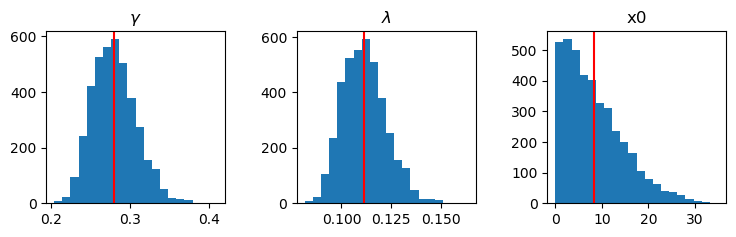

In [101]:
cnames=[L"\gamma",L"\lambda","x0"]
fig, axs = PyPlot.subplots(1, 3, figsize = (8,2))
for i in 1:3
    axs[i].hist(rawdata_sin[:,i+1],bins=20)
    axs[i].axvline(chns_sin.info[1].x[2][1][i+1,2],color="r")
    axs[i].set_title(cnames[i], ha="center", fontsize=12, color = "k");
end

fig.subplots_adjust(bottom=0.1, top=0.96, left=0.1, right=0.95,
                    wspace=0.4, hspace=0.1)

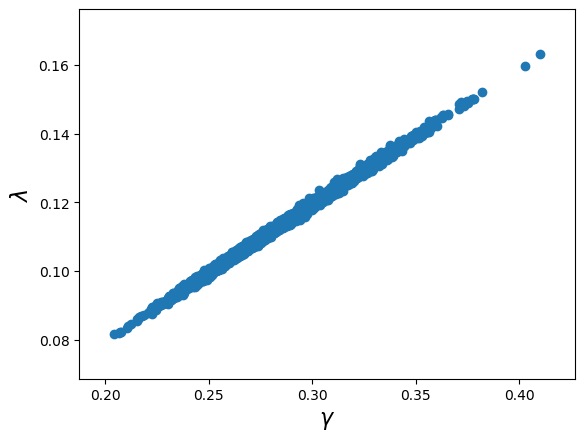

In [102]:
fig, ax = PyPlot.subplots()
ax.scatter(rawdata_sin[:,2],rawdata_sin[:,3],marker = "o")
ax.set_ylabel(L"\lambda",fontsize=16)
ax.set_xlabel(L"\gamma",fontsize=16);

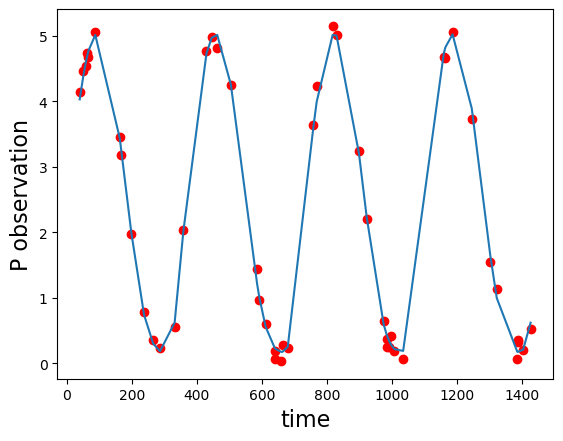

In [114]:
fig, ax = PyPlot.subplots()
ax.scatter(t_obs_sin,obs_sin,color="r")
ax.plot(t_obs_sin,chns_sin.info[1].x[2][1][5:end,2])
ax.set_ylabel("P observation",fontsize=16)
ax.set_xlabel("time",fontsize=16);